# Introduction

Dans ce notebook nous allons effectuer trois taches:
* l'analyse exploratoire (exploration et netooyage) de nos données
* traitement du texte
* extraction des features textes

# Analyse exploratoire ds données

## Import des librairies

In [2]:
%time
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import sklearn

from matplotlib import pyplot as plt

import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords, wordnet, brown
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Intallation du package contractions- https://github.com/kootenpv/contractions
!pip install contractions
import contractions


print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
print("re version:", re.__version__)
print("nltk version:", nltk.__version__)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Version info.: sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
pandas version: 2.2.2
numpy version: 2.0.2
skearn version: 1.6.1
re version: 2.2.1
nltk version: 3.9.1


## Chargement des données

In [3]:
path = "/content/drive/MyDrive/data/sentiments"
#path = "./data/sentiments"

In [4]:
%time
column_names = ['target', 'id', 'posted_at', 'QUERY', 'posted_by', 'content']
tweets_df = pd.read_csv(path+"/training.1600000.processed.noemoticon.csv", encoding_errors='ignore', names=column_names)
display(tweets_df.shape)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


(1600000, 6)

## Exploration

In [5]:
tweets_df.head()

,target,id,posted_at,QUERY,posted_by,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   target     1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   posted_at  1600000 non-null  object
 3   QUERY      1600000 non-null  object
 4   posted_by  1600000 non-null  object
 5   content    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
tweets_df.isna().sum()

,0
target,0
id,0
posted_at,0
QUERY,0
posted_by,0
content,0


Aucune valeur manquante n'a été detectée

In [8]:
tweets_df.QUERY.value_counts()

,count
QUERY,
NO_QUERY,1600000


Nous allons supprimer la colonne 'QUERY' car elle a une unique valeur qui n'apporte aucune variance à notre jeu de donnée.

In [9]:
tweets_df.drop(columns=['QUERY'], inplace=True)

In [10]:
tweets_df.head()

,target,id,posted_at,posted_by,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
tweets_df.target.value_counts()

,count
target,
0,800000
4,800000


TARGET a deux valeurs 0 et 4, pour plus de lisibilité nous allons remplacer par 1 ainsi npus aurons deux valeurs qui decrivent mieux la problématique etudiée (sentiment: 0-> positif et 1-> negatif)

In [12]:
tweets_df.target = tweets_df.target.replace(to_replace=4, value=1)

Les classes sont equilibrées

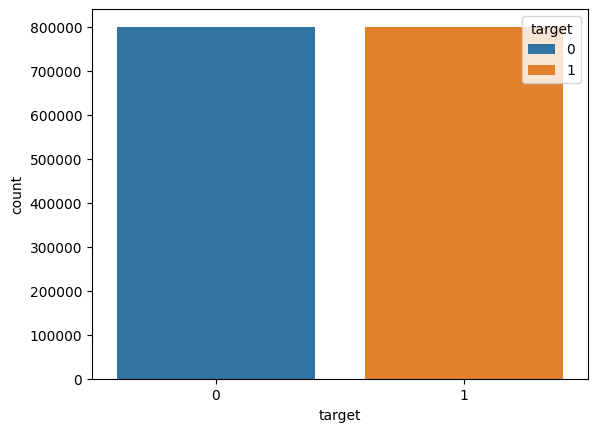

In [13]:
fig, ax = plt.subplots()
sns.countplot(data=tweets_df, x='target', ax=ax, hue='target')
xticks = ax.xaxis.get_ticks_position()
ax.xaxis.set_ticks([0, 1])
plt.show()

> Conversion explicite de la colonne **posted_at** en datetime


In [14]:
# avant
tweets_df.posted_at.dtypes

dtype('O')

In [15]:
# Suppression de 'PDT' de la chaîne
tweets_df['posted_at'] = tweets_df['posted_at'].str.replace("PDT", "", regex=False).str.strip()

# Conversion en datetime sans timezone
tweets_df['posted_at'] = pd.to_datetime(tweets_df['posted_at'], errors='coerce')

# Localisation de la timezone (US Pacific Time)
tweets_df['posted_at'] = tweets_df['posted_at'].dt.tz_localize('US/Pacific', ambiguous='NaT', nonexistent='NaT')


In [16]:
# aprés
tweets_df.posted_at.dtypes

datetime64[ns, US/Pacific]

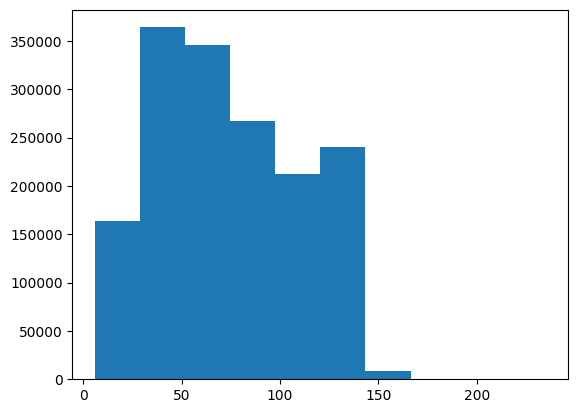

In [17]:
text_length = tweets_df['content'].str.len()
plt.hist(text_length)
plt.show()

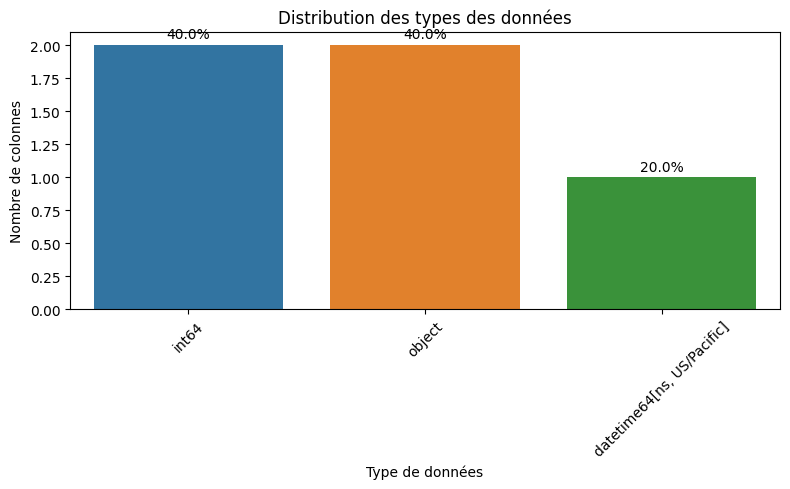

In [18]:
dtype_counts = tweets_df.dtypes.value_counts().reset_index()
dtype_counts.columns = ['dtype', 'count']

total = dtype_counts['count'].sum()
dtype_counts['percent'] = (dtype_counts['count'] / total * 100).round(1)
dtype_counts['dtype'] = dtype_counts['dtype'].astype(str)


plt.figure(figsize=(8, 5))
sns.barplot(data=dtype_counts, x='dtype', y='count', hue='dtype')

for index, row in dtype_counts.iterrows():
    plt.text(x=index, y=row['count'] + total * 0.01, s=f"{row['percent']}%", ha='center')

plt.title("Distribution des types des données")
plt.xlabel("Type de données")
plt.ylabel("Nombre de colonnes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



> Tweets dupliqués



In [19]:
tweets_df[tweets_df.duplicated(subset=['id', 'content'])]

,target,id,posted_at,posted_by,content
800261,1,1467863684,2009-04-06 22:33:35-07:00,DjGundam,Awwh babs... you look so sad underneith that s...
800300,1,1467880442,2009-04-06 22:38:04-07:00,iCalvin,Haven't tweeted nearly all day Posted my webs...
801280,1,1468053611,2009-04-06 23:28:09-07:00,mariejamora,@hellobebe I also send some updates in plurk b...
801573,1,1468100580,2009-04-06 23:42:57-07:00,cristygarza,good night swetdreamss to everyonee and jare...
801650,1,1468115720,2009-04-06 23:48:00-07:00,WarholGirl,@ientje89 aw i'm fine too thanks! yeah i miss ...
...,...,...,...,...,...
1598780,1,2193278017,2009-06-16 08:14:22-07:00,janiecwales,oh dear HH is back please twitter do somethi...
1599298,1,2193403830,2009-06-16 08:24:44-07:00,lauren__x33,english exam went okay revising for fre...
1599385,1,2193428118,2009-06-16 08:26:44-07:00,bubbles00,"finally finished typing!!!! Woohoooo , still ..."
1599440,1,2193451289,2009-06-16 08:28:37-07:00,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."


In [20]:
tweets_df.loc[tweets_df.id==2193576442]

,target,id,posted_at,posted_by,content
524688,0,2193576442,2009-06-16 08:38:45-07:00,emma_b_xox,Had an injection today. Not fun the rrst of t...
1599931,1,2193576442,2009-06-16 08:38:45-07:00,emma_b_xox,Had an injection today. Not fun the rrst of t...


L’exemple ci-dessous illustre un cas de duplication : deux observations partagent le même identifiant (`id`) et le même contenu (`content`). Cependant, elles sont associées à des **labels différents** (`0` pour l’une et `1` pour l’autre), ce qui crée une incohérence.

Pour gérer ce type de cas, nous adoptons la stratégie suivante :

- **Si les observations dupliquées ont des labels différents** :  
  *Nous supprimons les deux*, car cette contradiction rend le label peu fiable et pourrait introduire du bruit dans l’apprentissage du modèle.

- **Si les observations dupliquées ont le même label** :  
  *Nous ne conservons qu’une seule occurrence*, afin de réduire les redondances et éviter de biaiser le modèle avec des doublons.

> Cette stratégie permet de nettoyer les données de manière prudente, en écartant les cas ambigus et en limitant la surreprésentation de certains exemples.



In [21]:
# les doublons ayant les memes labels
print(tweets_df[tweets_df.duplicated(subset=['id', 'content', 'target'])])

Empty DataFrame
Columns: [target, id, posted_at, posted_by, content]
Index: []


In [22]:
# les doublons ayant differents labels
duplicate_rows = tweets_df.duplicated(subset=['id', 'content'], keep=False)
display(tweets_df[duplicate_rows].info())

<class 'pandas.core.frame.DataFrame'>
Index: 3370 entries, 213 to 1599931
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype                     
---  ------     --------------  -----                     
 0   target     3370 non-null   int64                     
 1   id         3370 non-null   int64                     
 2   posted_at  3370 non-null   datetime64[ns, US/Pacific]
 3   posted_by  3370 non-null   object                    
 4   content    3370 non-null   object                    
dtypes: datetime64[ns, US/Pacific](1), int64(2), object(2)
memory usage: 158.0+ KB


None

In [23]:
# Suppression des doublons
tweets_df = tweets_df[~(duplicate_rows)]

In [24]:
tweets_df.shape

(1596630, 5)



> suppression des doublons (user, message)



In [25]:
rows = tweets_df.duplicated(subset=['content', 'posted_by'], keep=False)
rows.sum()

np.int64(5431)

In [26]:
duplicated_contents = tweets_df[rows]

In [27]:
duplicated_contents

,target,id,posted_at,posted_by,content
238,0,1467872759,2009-04-06 22:35:59-07:00,Augustina22CA,"im lonely keep me company! 22 female, california"
599,0,1467963477,2009-04-06 23:01:15-07:00,Augustina22,"im lonely keep me company! 22 female, new york"
2149,0,1468316454,2009-04-07 00:56:00-07:00,Augustina22CA,"im lonely keep me company! 22 female, california"
3469,0,1468602199,2009-04-07 02:40:02-07:00,ammaryasir,"cant eat, drink or breath properly thanks to t..."
3732,0,1468662767,2009-04-07 03:01:40-07:00,FranciscoAndre,I'm not liking that new iTunes Pricing at all....
...,...,...,...,...,...
1598959,1,2193318357,2009-06-16 08:17:40-07:00,ummsistweets,cedar point with my biffs
1599353,1,2193427113,2009-06-16 08:26:38-07:00,parawhore182,Im busy. Drooling. Over this video. ;) but ye...
1599354,1,2193427134,2009-06-16 08:26:38-07:00,parawhore182,Im busy. Drooling. Over this video. ;) but ye...
1599377,1,2193427910,2009-06-16 08:26:43-07:00,ummsistweets,cedar point with my biffs


In [28]:
tweets_df[tweets_df['posted_by'].str.strip() == 'ummsistweets']

,target,id,posted_at,posted_by,content
1298633,1,2005308803,2009-06-02 09:30:41-07:00,ummsistweets,sew excited
1598959,1,2193318357,2009-06-16 08:17:40-07:00,ummsistweets,cedar point with my biffs
1599377,1,2193427910,2009-06-16 08:26:43-07:00,ummsistweets,cedar point with my biffs


In [29]:
# les doublons ayant les memes labels
duplicate_rows = tweets_df.duplicated(subset=['content', 'posted_by', 'target'])
display(tweets_df[duplicate_rows].info())

<class 'pandas.core.frame.DataFrame'>
Index: 3541 entries, 2149 to 1599531
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype                     
---  ------     --------------  -----                     
 0   target     3541 non-null   int64                     
 1   id         3541 non-null   int64                     
 2   posted_at  3541 non-null   datetime64[ns, US/Pacific]
 3   posted_by  3541 non-null   object                    
 4   content    3541 non-null   object                    
dtypes: datetime64[ns, US/Pacific](1), int64(2), object(2)
memory usage: 166.0+ KB


None

In [30]:
# Suppression des doublons
tweets_df = tweets_df.drop_duplicates(subset=['content', 'posted_by'], keep='first')
tweets_df.shape

(1593071, 5)

In [31]:
tweets_df[tweets_df['posted_by'].str.strip() == 'ummsistweets']

,target,id,posted_at,posted_by,content
1298633,1,2005308803,2009-06-02 09:30:41-07:00,ummsistweets,sew excited
1598959,1,2193318357,2009-06-16 08:17:40-07:00,ummsistweets,cedar point with my biffs


In [32]:
# les doublons ayant differents labels
print(tweets_df[tweets_df.duplicated(subset=['id', 'content'])])

Empty DataFrame
Columns: [target, id, posted_at, posted_by, content]
Index: []


# Nettoyage du contenu

L’approche la plus courante dans le nettoyage de texte consiste à uniformiser la casse (mettre en majuscules ou en minuscules), en raison de la diversité des capitalisations dans la formation des phrases. Cette technique permet de projeter tous les mots du texte et du document dans le même espace de caractéristiques. Toutefois, elle peut poser problème dans des cas exceptionnels comme "USA" ou "UK", ce qui peut être résolu en utilisant des techniques de correction des fautes de frappe, de traitement du langage familier, des acronymes ou des abréviations informelles.[link text](https://)

## Mise en minuscule

In [33]:
tweets_df["content_clean"] = tweets_df["content"].apply(lambda x: x.lower())
display(tweets_df.head())

,target,id,posted_at,posted_by,content,content_clean
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan i dived many times for the ball. man...
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."


## Étendre les contractions

Nous utilisons le package [contractions](https://github.com/kootenpv/contractions) pour développer les contractions en anglais, par exemple `we'll` devient `we will`, ou `we shouldn't've` devient `we should not have`.

In [34]:
%time
# Test
test_text = """
            Y'all can't expand contractions I'd think. I'd like to know how I'd done that!
            We're going to the zoo and I don't think I'll be home for dinner.
            Theyre going to the zoo and she'll be home for dinner.
            We should've do it in here but we shouldn't've eat it
            """
print("Test: ", contractions.fix(test_text))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Test:  
            You all cannot expand contractions I would think. I would like to know how I would done that! 
            We are going to the zoo and I do not think I will be home for dinner.
            They Are going to the zoo and she will be home for dinner.
            We should have do it in here but we should not have eat it
            


In [35]:
%time
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: contractions.fix(x))

# double check
print(tweets_df["content"][12])
print(tweets_df["content_clean"][12])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
@caregiving i could not bear to watch it.  and i thought the ua loss was embarrassing . . . . .


## Suppression du bruit (Noise Removal)

Les données textuelles peuvent contenir divers caractères inutiles ou de la ponctuation, tels que des URLs, des balises HTML, des caractères non-ASCII, ou d'autres caractères spéciaux (symboles, emojis, et autres caractères graphiques).

### Suppression des URLs

In [36]:
def remove_URL(text):
    """
        Supprime des URLs du texte
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [37]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_URL(x))

print(tweets_df["content"][37])
print(tweets_df["content_clean"][37])

@MissXu sorry! bed time came here (GMT+1)   http://is.gd/fNge
@missxu sorry! bed time came here (gmt+1)   


### Suppression des tags HTML

In [38]:
def remove_html(text):
    """
        Supprime les tags HTML du texte
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

In [39]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_html(x))

### Remove Non-ASCI

In [40]:
def remove_non_ascii(text):
    """
        supprime les caractères non ASCII du texte
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable])

In [41]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_non_ascii(x))

## Suppression des ponctuations

In [42]:
def remove_punct(text):
    """
        supprime les ponctuations du texte
    """
    return text.translate(str.maketrans('', '', string.punctuation))

In [43]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_punct(x))

print(tweets_df["content"][5])
print(tweets_df["content_clean"][5])
print("---"*10)
print(tweets_df["content"][7597])
print(tweets_df["content_clean"][7597])

@Kwesidei not the whole crew 
kwesidei not the whole crew 
------------------------------
I just got my first fail whale...  @Twitter.
i just got my first fail whale  twitter


# Prétraitement du texte

## Tokenization


In [44]:
%%time
nltk.download("punkt_tab")
tweets_df['tokenized'] = tweets_df['content_clean'].apply(word_tokenize)
tweets_df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


CPU times: user 2min 31s, sys: 1.81 s, total: 2min 32s
Wall time: 2min 34s


,target,id,posted_at,posted_by,content,content_clean,tokenized
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that is a bummer you should...,"[switchfoot, awww, that, is, a, bummer, you, s..."
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f..."
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...,"[kenichan, i, dived, many, times, for, the, ba..."
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it is not behaving at all i...,"[nationwideclass, no, it, is, not, behaving, a..."


## Suppression des mots vides (et/ou des mots fréquents / rares)

Les mots vides (*stop words*) sont des mots courants dans une langue qui apparaissent très fréquemment, mais n’apportent que peu ou pas d’information utile à la phrase. Par exemple, des mots comme {“a”, “about”, “above”, “across”, “after”, “afterward”, “again”, ...} peuvent être considérés comme des mots vides. Traditionnellement, on choisit de les supprimer lors de la phase de prétraitement du texte.

In [45]:
%%time
nltk.download("stopwords")

stop = set(stopwords.words('english'))
tweets_df['stopwords_removed'] = tweets_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
tweets_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 7.87 s, sys: 139 ms, total: 8.01 s
Wall time: 8.01 s


,target,id,posted_at,posted_by,content,content_clean,tokenized,stopwords_removed
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that is a bummer you should...,"[switchfoot, awww, that, is, a, bummer, you, s...","[switchfoot, awww, bummer, shoulda, got, david..."
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...,"[kenichan, i, dived, many, times, for, the, ba...","[kenichan, dived, many, times, ball, managed, ..."
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it is not behaving at all i...,"[nationwideclass, no, it, is, not, behaving, a...","[nationwideclass, behaving, mad, see]"


## Étiquetage (POS Tagging)

L’étiquetage (*Part of Speech Tagging*, ou POS tagging) consiste à identifier la nature grammaticale de chaque mot dans un texte (nom, verbe, adjectif, etc.).

In [46]:
%%time
nltk.download('wordnet')
nltk.download('brown')
wordnet_map = {"N":wordnet.NOUN,
               "V":wordnet.VERB,
               "J":wordnet.ADJ,
               "R":wordnet.ADV
              }

train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)

    # map the pos tagging output with wordnet output
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


CPU times: user 4.55 s, sys: 151 ms, total: 4.71 s
Wall time: 4.82 s


In [47]:
pos_tag_wordnet(tweets_df['stopwords_removed'][2])

[('kenichan', 'n'),
 ('dived', 'n'),
 ('many', 'n'),
 ('times', 'n'),
 ('ball', 'n'),
 ('managed', 'v'),
 ('save', 'v'),
 ('50', 'n'),
 ('rest', 'n'),
 ('go', 'v'),
 ('bounds', 'n')]

In [ ]:
%time

tweets_df['combined_postag_wnet'] = tweets_df['stopwords_removed'].apply(lambda x: pos_tag_wordnet(x))

tweets_df.head()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


## Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

### Lemmatization sans POS Tagging:

In [ ]:
%time

lemmatizer = WordNetLemmatizer()

tweets_df['lemmatize_word_wo_pos'] = tweets_df['stopwords_removed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
tweets_df.head()

In [ ]:
print(tweets_df["combined_postag_wnet"][29])
print(tweets_df["lemmatize_word_wo_pos"][29])

### Lemmatization avec POS Tagging:

In [ ]:
%time

lemmatizer = WordNetLemmatizer()

tweets_df['lemmatize_word_w_pos'] = tweets_df['combined_postag_wnet'].apply(lambda x: lemmatize_word(x))
tweets_df['lemmatize_text'] = [' '.join(map(str, l)) for l in tweets_df['lemmatize_word_w_pos']]
tweets_df.head()

In [ ]:
print(tweets_df["content"][8])
print(tweets_df["combined_postag_wnet"][8])
print(tweets_df["lemmatize_word_wo_pos"][8])
print(tweets_df["lemmatize_word_w_pos"][8])

Comparison between original text and the lammatized text:

In [ ]:
display(tweets_df["content"][0], tweets_df["lemmatize_text"][0])

# Extraction des Features texte



## BOW - CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def cv(data, ngram = 1, MAX_NB_WORDS = 75000):
    count_vectorizer = CountVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = count_vectorizer.fit_transform(data).toarray()
    print("count vectorize with", str(np.array(emb).shape[1]), "features")
    return emb, count_vectorizer

In [ ]:
def print_out(emb, feat, ngram, compared_sentence=0):
    print(ngram,"bag-of-words: ")
    print(feat.get_feature_names_out(), "\n")
    print(ngram,"bag-of-feature: ")
    print(test_cv_1gram.vocabulary_, "\n")
    print("BoW matrix:")
    print(pd.DataFrame(emb.transpose(), index = feat.get_feature_names_out()).head(), "\n")
    print(ngram,"vector example:")
    print(tweets_df["lemmatize_text"][compared_sentence])
    print(emb[compared_sentence], "\n")

In [ ]:
test_corpus = tweets_df["lemmatize_text"][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_cv_em_1gram, test_cv_1gram = cv(test_corpus, ngram=1)
print_out(test_cv_em_1gram, test_cv_1gram, ngram="Uni-gram")

In [ ]:
test_cv_em_2gram, test_cv_2gram = cv(test_corpus, ngram=2)
print_out(test_cv_em_2gram, test_cv_2gram, ngram="Bi-gram")

In [ ]:
test_cv_em_3gram, test_cv_3gram = cv(test_corpus, ngram=3)
print_out(test_cv_em_2gram, test_cv_2gram, ngram="Tri-gram")

In [ ]:
%time

# implementation dans tous le dataset
tweets_df_corpus = tweets_df["lemmatize_text"].tolist()
tweets_df_em_1gram, vc_1gram = cv(tweets_df_corpus, 1)
tweets_df_em_2gram, vc_2gram = cv(tweets_df_corpus, 2)
tweets_df_em_3gram, vc_3gram = cv(tweets_df_corpus, 3)

print(len(tweets_df_corpus))
print(tweets_df_em_1gram.shape)
print(tweets_df_em_2gram.shape)
print(tweets_df_em_3gram.shape)

In [ ]:
del train_df_em_1gram, train_df_em_2gram, train_df_em_3gram

### Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF(data, ngram = 1, MAX_NB_WORDS = 75000):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

In [ ]:
test_corpus = tweets_df["lemmatize_text"][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_tfidf_em_1gram, test_tfidf_1gram = TFIDF(test_corpus, ngram=1)
print_out(test_tfidf_em_1gram, test_tfidf_1gram, ngram="Uni-gram")

The test corpus:  ['deed reason earthquake may allah forgive u', 'forest fire near la ronge sask canada', 'resident ask shelter place notified officer evacuation shelter place order expect', '13000 people receive wildfire evacuation order california', 'get send photo ruby alaska smoke wildfire pours school'] 

tf-idf with 35 features
Uni-gram bag-of-words: 
['13000', 'alaska', 'allah', 'ask', 'california', 'canada', 'deed', 'earthquake', 'evacuation', 'expect', 'fire', 'forest', 'forgive', 'get', 'la', 'may', 'near', 'notified', 'officer', 'order', 'people', 'photo', 'place', 'pours', 'reason', 'receive', 'resident', 'ronge', 'ruby', 'sask', 'school', 'send', 'shelter', 'smoke', 'wildfire'] 

Uni-gram bag-of-feature: 
{'deed': 6, 'reason': 24, 'earthquake': 7, 'may': 15, 'allah': 2, 'forgive': 12, 'forest': 11, 'fire': 10, 'near': 16, 'la': 14, 'ronge': 27, 'sask': 29, 'canada': 5, 'resident': 26, 'ask': 3, 'shelter': 32, 'place': 22, 'notified': 17, 'officer': 18, 'evacuation': 8, 'or

In [ ]:
test_tfidf_em_2gram, test_tfidf_2gram = TFIDF(test_corpus, ngram=2)
print_out(test_tfidf_em_2gram, test_tfidf_2gram, ngram="Bi-gram")

tf-idf with 34 features
Bi-gram bag-of-words: 
['13000 people', 'alaska smoke', 'allah forgive', 'ask shelter', 'deed reason', 'earthquake may', 'evacuation order', 'evacuation shelter', 'fire near', 'forest fire', 'get send', 'la ronge', 'may allah', 'near la', 'notified officer', 'officer evacuation', 'order california', 'order expect', 'people receive', 'photo ruby', 'place notified', 'place order', 'pours school', 'reason earthquake', 'receive wildfire', 'resident ask', 'ronge sask', 'ruby alaska', 'sask canada', 'send photo', 'shelter place', 'smoke wildfire', 'wildfire evacuation', 'wildfire pours'] 

Bi-gram bag-of-feature: 
{'deed': 6, 'reason': 24, 'earthquake': 7, 'may': 15, 'allah': 2, 'forgive': 12, 'forest': 11, 'fire': 10, 'near': 16, 'la': 14, 'ronge': 27, 'sask': 29, 'canada': 5, 'resident': 26, 'ask': 3, 'shelter': 32, 'place': 22, 'notified': 17, 'officer': 18, 'evacuation': 8, 'order': 19, 'expect': 9, '13000': 0, 'people': 20, 'receive': 25, 'wildfire': 34, 'califor

In [ ]:
test_tfidf_em_3gram, test_tfidf_3gram = TFIDF(test_corpus, ngram=3)
print_out(test_tfidf_em_3gram, test_tfidf_3gram, ngram="Tri-gram")

tf-idf with 30 features
Tri-gram bag-of-words: 
['13000 people receive', 'alaska smoke wildfire', 'ask shelter place', 'deed reason earthquake', 'earthquake may allah', 'evacuation order california', 'evacuation shelter place', 'fire near la', 'forest fire near', 'get send photo', 'la ronge sask', 'may allah forgive', 'near la ronge', 'notified officer evacuation', 'officer evacuation shelter', 'people receive wildfire', 'photo ruby alaska', 'place notified officer', 'place order expect', 'reason earthquake may', 'receive wildfire evacuation', 'resident ask shelter', 'ronge sask canada', 'ruby alaska smoke', 'send photo ruby', 'shelter place notified', 'shelter place order', 'smoke wildfire pours', 'wildfire evacuation order', 'wildfire pours school'] 

Tri-gram bag-of-feature: 
{'deed': 6, 'reason': 24, 'earthquake': 7, 'may': 15, 'allah': 2, 'forgive': 12, 'forest': 11, 'fire': 10, 'near': 16, 'la': 14, 'ronge': 27, 'sask': 29, 'canada': 5, 'resident': 26, 'ask': 3, 'shelter': 32, 'p

In [ ]:
%time

# implement into the whole dataset
train_df_corpus = train_df["lemmatize_text"].tolist()
train_df_tfidf_1gram, tfidf_1gram = TFIDF(train_df_corpus, 1)
train_df_tfidf_2gram, tfidf_2gram = TFIDF(train_df_corpus, 2)
train_df_tfidf_3gram, tfidf_3gram = TFIDF(train_df_corpus, 3)

print(len(train_df_corpus))
print(train_df_tfidf_1gram.shape)
print(train_df_tfidf_1gram.shape)
print(train_df_tfidf_1gram.shape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
tf-idf with 15527 features
tf-idf with 45570 features
tf-idf with 43751 features
7613
(7613, 15527)
(7613, 15527)
(7613, 15527)


In [ ]:
del train_df_tfidf_1gram, train_df_tfidf_2gram, train_df_tfidf_3gram

<a id="Word_Embedding"></a>

## Word Embedding:

> **Word vectors** are numerical vector representations of word semantics, or meaning, including literal and implied meaning. So word vectors can capture the connotation of words, like “peopleness,” “animalness,” “placeness,” “thingness,” and even “conceptness.” And they combine all that into a dense vector (no zeros) of floating point values. This dense vector enables queries and logical reasoning.

(source: [Natural Language Processing in Action](https://www.manning.com/books/natural-language-processing-in-action))

> Even though we have syntactic word representations, it does not mean that the model captures the semantics meaning of the words. On the other hand, bag-of-word models do not respect the semantics of the word. For example, words “airplane”, “aeroplane”, “plane”, and “aircraft” are often used in the same context. However, the vectors corresponding to these words are orthogonal in the bag-of-words model. This issue presents a serious problem to understanding sentences within the model. The other problem in the bag-of-word is that the order of words in the phrase is not respected. The n-gram does not solve this problem so a similarity needs to be found for each word in the sentence. Many researchers worked on word embedding to solve this problem. The Word2Vec propose a simple single-layer architecture based on the inner product between two word vectors.

> Word embedding is a feature learning technique in which each word or phrase from the vocabulary is mapped to a N dimension vector of real numbers. Various word embedding methods have been proposed to translate unigrams into understandable input for machine learning algorithms. This work focuses on Word2Vec, GloVe, and FastText, three of the most common methods that have been successfully used for deep learning techniques.

(source: [Text Classification Algorithms: A Survey](https://arxiv.org/abs/1904.08067))

<a id="Basic_Word_Embedding"></a>
### Basic Word Embedding Methods:

<a id="Word2Vec"></a>
#### Word2Vec:

[T. Mikolov et al.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) presented the Word2vec in 2013, which learns the meaning of words merely by processing a large corpus of unlabeled text. The Word2Vec approach uses shallow neural networks with two hidden layers, continuous bag-of-words (CBOW), and the Skip-gram model to create a high dimension vector for each word. This unsupervised nature of Word2vec is what makes it so powerful. The world is full of unlabeled, uncategorized, unstructured natural language text.

We will implement the Word2vec via gensim libary with the pre-trained word vectors on the dataset Google News corpus (source: https://code.google.com/archive/p/word2vec/) and see the embedding output on the sample sentence from the our dataset.

[Back To Table of Contents](#top_section)

In [ ]:
%time

import gensim
print("gensim version:", gensim.__version__)

word2vec_path = "../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"

# we only load 200k most common words from Google News corpus
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
gensim version: 3.8.3


Compare the similarity between "cat" vs. "kitten" and "cat" vs. "cats"

In [ ]:
print(word2vec_model.similarity('cat', 'kitten'))
print(word2vec_model.similarity('cat', 'cats'))

0.74649847
0.80993783


In [ ]:
def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
    """
        Calculate average embedding value of sentence from each word vector
    """

    if len(tokens_list)<1:
        return np.zeros(k)

    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]

    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_embeddings(vectors, text, generate_missing=False, k=300):
    """
        create the sentence embedding
    """
    embeddings = text.apply(lambda x: get_average_vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [ ]:
%time

embeddings_word2vec = get_embeddings(word2vec_model, train_df["lemmatize_text"], k=300)

print("Embedding matrix size", len(embeddings_word2vec), len(embeddings_word2vec[0]))
print("The sentence: \"%s\" got embedding values: " % train_df["lemmatize_text"][0])
print(embeddings_word2vec[0])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
Embedding matrix size 7613 300
The sentence: "deed reason earthquake may allah forgive u" got embedding values: 
[-0.10973104  0.09386771  0.02338518  0.08328102 -0.0219574   0.02885873
 -0.08006577 -0.04429408 -0.04224214  0.02420189 -0.03073424 -0.06804257
 -0.16214498  0.04603213 -0.10248093  0.07793608  0.0992388   0.11692011
 -0.01385716  0.01890346 -0.19027274 -0.03666796  0.06822132  0.0259938
 -0.06404114  0.01582078 -0.16466123  0.02864947 -0.00298782 -0.0321074
 -0.03302729  0.0175467  -0.05769275 -0.08599418 -0.09155273  0.0423119
 -0.14993068  0.07241385 -0.04759707  0.06599499 -0.02213396 -0.01985386
  0.03608922  0.0730242   0.04145477 -0.0592204  -0.03368414 -0.14240374
 -0.11207799  0.04079474 -0.13815162  0.18583752 -0.0264631   0.13613746
  0.04344395  0.10146368 -0.1568371  -0.09093766  0.01943534 -0.12862142
 -0.09729658 -0.08818272 -0.1499038  -0.02244436 -0.04221671 -0.14467076
 -0.08727664  0.087

In [ ]:
del embeddings_word2vec

<a id="GloVe"></a>

#### Global Vectors for Word Representation (GloVe):
> Another powerful word embedding technique that has been used for text classiﬁcation is [Global Vectors (GloVe)](https://nlp.stanford.edu/pubs/glove.pdf). The approach is very similar to the Word2Vec method, where each word is presented by a high dimension vector and trained based on the surrounding words over a huge corpus. The pre-trained word embedding used in many works is based on 400,000 vocabularies trained over Wikipedia 2014 and Gigaword 5 as the corpus and 50 dimensions for word presentation. GloVe also provides other pre-trained word vectorizations with 100, 200, 300 dimensions which are trained over even bigger corpora, including Twitter content.

(source: [Text Classification Algorithms: A Survey](https://arxiv.org/abs/1904.08067))

We will create our GloVe's sentence embeddings  via gensim libary with the pre-trained word vectors on the dataset from Wikipedia 2014 + Gigaword 5 (source: https://github.com/stanfordnlp/GloVe) and see the embedding output on the sample sentence from the our dataset.


[Back To Table of Contents](#top_section)

In [ ]:
%time

from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = "../input/glove6b/glove.6B.300d.txt"
word2vec_output_file = "glove.6B.100d.txt.word2vec"
glove2word2vec(glove_input_file, word2vec_output_file)

# we only load 200k most common words from Google New corpus
glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False, limit=200000)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


Compare the similarity between "cat" vs. "kitten" and "cat" vs. "cats" from GloVe

In [ ]:
print(glove_model.similarity('cat', 'kitten'))
print(glove_model.similarity('cat', 'cats'))

0.43046176
0.68158364


In [ ]:
%time

embeddings_glove = get_embeddings(glove_model, train_df["lemmatize_text"], k=300)

print("Embedding matrix size", len(embeddings_glove), len(embeddings_glove[0]))
print("The sentence: \"%s\" got embedding values: " % train_df["lemmatize_text"][0])
print(embeddings_glove[0])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Embedding matrix size 7613 300
The sentence: "deed reason earthquake may allah forgive u" got embedding values: 
[-0.24644262  0.05410434 -0.27450693 -0.06188807 -0.46284731 -0.00939752
 -0.05414152  0.13743693 -0.22479226 -0.98268882  0.09007366  0.053033
 -0.28044198  0.02101397 -0.03703022 -0.12029742 -0.21756712  0.35917495
  0.18462457 -0.04608281 -0.10460077 -0.08015574 -0.02202645  0.11273405
 -0.12068953  0.12194095  0.14686729  0.15968064  0.29633239 -0.30258431
 -0.11143976  0.35128362 -0.19570481 -0.0432561  -0.57752143  0.05718431
  0.197115   -0.36596643 -0.14253749  0.14517167 -0.01787278  0.07752722
 -0.35558786  0.49918029 -0.25823491 -0.20787183  0.17671538 -0.06122703
  0.01860436  0.00956815  0.01008621  0.18646614 -0.05261453  0.09435026
  0.0347649   0.18527218  0.03771786 -0.00734357  0.0737335  -0.39638246
  0.32128479  0.18159559  0.14429088  0.09128076 -0.08779434 -0.09699717
 -0.1332329   0.128113

In [ ]:
del embeddings_glove

<a id="FastText"></a>

#### FastText:
> Many other word embedding representations ignore the morphology of words by assigning a distinct vector to each word ([Enriching Word Vectors with Subword Information](https://arxiv.org/abs/1607.04606)). Facebook AI Research lab released a novel technique to solve this issue by introducing a new word embedding method called FastText. Each word, w, is represented as a bag of character n-gram. For example, given the word “introduce” and n = 3, FastText will produce the following representation composed of character tri-grams: < in, int, ntr, tro, rod, odu, duc, uce, ce >
> Note that the sequence <int>, corresponding to the word here is different from the tri-gram “int” from the word introduce.

(source: [Text Classification Algorithms: A Survey](https://arxiv.org/abs/1904.08067))

We will create our FastText's sentence embeddings via gensim libary with the pre-trained word vectors from the Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (source: https://fasttext.cc/docs/en/english-vectors.html) and see the embedding output on the sample sentence from the our dataset.


[Back To Table of Contents](#top_section)

In [ ]:
%time

from gensim.models.fasttext import FastText

fasttext_path = "../input/fasttext-wikinews/wiki-news-300d-1M.vec"
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False, limit=200000)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


Compare the similarity between "cat" vs. "kitten" and "cat" vs. "cats" from FastText

In [ ]:
print(fasttext_model.similarity('cat', 'kitten'))
print(fasttext_model.similarity('cat', 'cats'))

0.7353649
0.8552809


In [ ]:
embeddings_fasttext = get_embeddings(fasttext_model, train_df["lemmatize_text"], k=300)

print("Embedding matrix size", len(embeddings_fasttext), len(embeddings_fasttext[0]))
print("The sentence: \"%s\" got embedding values: " % train_df["lemmatize_text"][0])
print(embeddings_fasttext[0])

Embedding matrix size 7613 300
The sentence: "deed reason earthquake may allah forgive u" got embedding values: 
[-8.09166668e-02  2.61404759e-02 -8.73142836e-02 -3.69428569e-02
  1.73714293e-02  4.03738089e-02  1.19119056e-02 -2.96238094e-02
  1.21804762e-01  4.34142850e-02 -2.36714286e-02 -2.98738095e-02
  5.00333325e-02 -2.49952377e-02 -2.62000006e-02  2.73166672e-02
 -1.57404756e-02 -1.61595243e-02 -2.85976184e-02  7.77619022e-02
 -1.63690476e-02 -1.13026191e-01 -3.10547621e-02 -2.75714294e-02
 -6.89023813e-02 -5.33142867e-02  2.94666670e-02  1.26283331e-01
  3.59476194e-02 -9.56166665e-02  4.42857155e-02  2.53380938e-02
 -1.39238087e-02 -2.98023802e-02  5.93452381e-02  6.58619040e-02
 -1.11547623e-02  1.53952374e-02  5.92904766e-02 -1.74500004e-02
 -2.33333374e-03 -9.57619045e-03 -9.73023806e-02 -3.89999918e-03
  2.21000003e-02  1.47904770e-02  4.90023823e-02  2.88071422e-02
  8.64047606e-02  3.05714297e-03 -1.81666667e-02 -4.32404758e-02
 -5.74880958e-01 -4.76190484e-03  1.785715

In [ ]:
del embeddings_fasttext

<a id="Advanced_methods"></a>

### Advanced Word Embedding Methods - Deep Contextualized Word Representations:

<a id="BERT"></a>
#### Bidirectional Encoder Representations from Transformers (BERT):
> BERT is a deep learning model that has given state-of-the-art results on a wide variety of natural language processing tasks. It stands for Bidirectional Encoder Representations for Transformers. It has been pre-trained on Wikipedia and BooksCorpus and requires task-specific fine-tuning.

> Lets understand BERT by breaking BERT abbreviation:
> * **Bidirectional**: BERT takes whole text passage as input and reads passage in both direction to understand the meaning of each word.
> * **Transformers**: BERT is based on a Deep Transformer network. Transformer network is a type of network that can process efficiently long texts by using attention. An attention is a mechanism to learn contextual relations between words (or sub-words) in a text.
> * **Encoder Representation**: Originally Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task, since BERT’s goal is to generate a language model only the encoder mechanism is necessary hence 'encoder representation'

> BERT is a multi-layer bidirectional Transformer encoder. There are two models introduced in the paper.
> * BERT base – 12 layers (transformer blocks), 12 attention heads, and 110 million parameters.
> * BERT Large – 24 layers, 16 attention heads and, 340 million parameters.


> How BERT performs Bidirectional training?
>
> BERT uses following two prediction models simultaneously with the goal of minimizing the combined loss function of the two strategies:
>
> * **Masked Language Model**: Before feeding word sequences into BERT, 15% of the words in each sequence are replaced with a [MASK] token. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence.
> * **Next Sentence Prediction**: The model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. During training, 50% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document, while in the other 50% a random sentence from the corpus is chosen as the second sentence. The assumption is that the random sentence will be disconnected from the first sentence.

Resources and further reading on BERT's explanation could be found in the great Kaggle notebooks and Blogs here:
* https://www.kaggle.com/abhinand05/bert-for-humans-tutorial-baseline-version-2
* https://www.kaggle.com/ratan123/in-depth-guide-to-google-s-bert
* https://www.kaggle.com/kksienc/comprehensive-nlp-tutorial-3-bert
* https://yashuseth.blog/2019/06/12/bert-explained-faqs-understand-bert-working/

We will create our sentence embeddings by BERT's pre-trained word vectors (Uncased) via Tensorflow (source: https://github.com/google-research/bert) and see the embedding output on the sample sentence from the our dataset. Noted that we will use the BERT isself tonkenizer.

[Back To Table of Contents](#top_section)

In [ ]:
%time

import tensorflow_hub as hub

# download the tonkenizer
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tokenization

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
%time

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

bert_input = bert_encode(train_df["text"].values, tokenizer, max_len=300)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [ ]:
print("Embedding tensor size", len(bert_input), len(bert_input[0]), len(bert_input[0][0]))
print("The sentence: \"%s\" got embedding values: " % train_df["lemmatize_text"][0])
print(bert_input[0])

Embedding tensor size 3 7613 300
The sentence: "deed reason earthquake may allah forgive u" got embedding values: 
[[  101  2256 15616 ...     0     0     0]
 [  101  3224  2543 ...     0     0     0]
 [  101  2035  3901 ...     0     0     0]
 ...
 [  101 23290  1012 ...     0     0     0]
 [  101  2610 11538 ...     0     0     0]
 [  101  1996  6745 ...     0     0     0]]


<a id="Comparison"></a>
## Comparison of Feature Extraction Techniques
Please refer to the below table as the Comparison between Feature Extraction Techniques, thanks to the paper [Text Classification Algorithms: A Survey](https://arxiv.org/abs/1904.08067) for all of their awesome works.

[Back To Table of Contents](#top_section)

| Model                               	| Advantages                                                                                                                                                                                                                                                                             	| Limitation                                                                                                                                                                                                                                                                                                                                                                  	|
|-------------------------------------	|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Weighted Words                      	| * Easy to compute<br>* Easy to compute the similarity between 2 documents using it<br>* Basic metric to extract the most descriptive terms in a document<br>* Works with an unknown word (e.g., New words in languages)                                                                	| * It does not capture the position in the text (syntactic)<br>* It does not capture meaning in the text (semantics)<br>* Common words effect on the results (e.g., “am”, “is”, etc.)                                                                                                                                                                                        	|
| TF-IDF                              	| * Easy to compute<br>* Easy to compute the similarity between 2 documents using it<br>* Basic metric to extract the most descriptive terms in a document<br>* Common words do not affect the results due to IDF (e.g., “am”, “is”, etc.)                                               	| * It does not capture the position in the text (syntactic)<br>* It does not capture meaning in the text (semantics)                                                                                                                                                                                                                                                         	|
| Word2Vec                            	| * It captures the position of the words in the text (syntactic)<br>* It captures meaning in the words (semantics)                                                                                                                                                                      	| * It cannot capture the meaning of the word from the text (fails to capture polysemy)<br>* It cannot capture out-of-vocabulary words from corpus                                                                                                                                                                                                                            	|
| GloVe (Pre-Trained)                 	| * It captures the position of the words in the text (syntactic)<br>* It captures meaning in the words (semantics)<br>* Trained on huge corpus                                                                                                                                          	| * It cannot capture the meaning of the word from the text (fails to capture polysemy)<br>* Memory consumption for storage<br>* It cannot capture out-of-vocabulary words from corpus                                                                                                                                                                                        	|
| GloVe (Trained)                     	| * It is very straightforward, e.g., to enforce the word vectors to capture sub-linear relationships in the vector space (performs better than Word2vec)<br>* Lower weight for highly frequent word pairs, such as stop words like “am”, “is”, etc. Will not dominate training progress 	| * Memory consumption for storage<br>* Needs huge corpus to learn<br>* It cannot capture out-of-vocabulary words from the corpus<br>* It cannot capture the meaning of the word from the text (fails to capture polysemy)                                                                                                                                                    	|
| FastText                            	| * Works for rare words (rare in their character n-grams which are still shared with other words<br>* Solves out of vocabulary words with n-gram in character level                                                                                                                     	| * It cannot capture the meaning of the word from the text (fails to capture polysemy)<br>* Memory consumption for storage<br>* Computationally is more expensive in comparing with GloVe and Word2Vec                                                                                                                                                                       	|
| Contextualized Word Representations 	| * It captures the meaning of the word from the text (incorporates context, handling polysemy)                                                                                                                                                                                          	| * Memory consumption for storage<br>* Improves performance notably on downstream tasks. Computationally is more expensive in comparison to others<br>* Needs another word embedding for all LSTM and feedforward layers<br>* It cannot capture out-of-vocabulary words from a corpus<br>* Works only sentence and document level (it cannot work for individual word level) 	|

<a id="References"></a>

# References:
<a id="Paper"></a>
## Paper:
* [Text Classification Algorithms: A Survey](https://arxiv.org/abs/1904.08067)

<a id="Books"></a>
## Books:
* [Natural Language Processing in Action](https://www.manning.com/books/natural-language-processing-in-action)
* [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf)

<a id="Blogs_Notebooks"></a>
## Blogs/ Notebooks:
* https://www.kaggle.com/abhinand05/bert-for-humans-tutorial-baseline-version-2
* https://www.kaggle.com/amar09/text-pre-processing-and-feature-extraction
* https://www.kaggle.com/ashishpatel26/beginner-to-intermediate-nlp-tutorial
* https://www.kaggle.com/ashutosh3060/nlp-basic-feature-creation-and-preprocessing
* https://www.kaggle.com/datafan07/disaster-tweets-nlp-eda-bert-with-transformers
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
* https://www.kaggle.com/kksienc/comprehensive-nlp-tutorial-3-bert
* https://www.kaggle.com/liananapalkova/simply-about-word2vec
* https://www.kaggle.com/ratan123/in-depth-guide-to-google-s-bert
* https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
* https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert
* https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
* https://yashuseth.blog/2019/06/12/bert-explained-faqs-understand-bert-working/
* https://gist.github.com/MrEliptik/b3f16179aa2f530781ef8ca9a16499af
* https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
* https://machinelearningmastery.com/gentle-introduction-bag-words-model/
* https://towardsdatascience.com/natural-language-processing-pipeline-93df02ecd03f


### I really appreciate your feedbacks, there would be some areas can be fixed and improved.
## If you liked my work please Upvote!
[Back To Table of Contents](#top_section)